# Blockstream API and Difficulty calculation

Blockstream API wrapper docs at <br>
[API docs](https://pypi.org/project/blockstream/)

Useful calculation resource

[Miner Daily](https://minerdaily.com/2021/how-are-bitcoins-difficulty-and-hash-rate-calculated/#How_Difficulty_is_Calculated)

In [1]:
from blockstream import blockexplorer
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import requests

# Block height

In [2]:
block_height = blockexplorer.get_last_block_height()
print(f'Current block height is {block_height}')

Current block height is 772550


## Difficulty Epoch </b>

In [3]:
epoch=(block_height//2016)+1
print(f'Current difficulty epoch is {epoch}')

Current difficulty epoch is 384


## Blocks to retarget

In [4]:
retarget=2016-block_height%2016
print(f'Blocks to retarget difficulty is {retarget}')

Blocks to retarget difficulty is 1594


<b>Trivia</b>: First difficulty adjustment in bitcoin network history was done on block 32256

## Difficulty stats and calculation

In [5]:
block = blockexplorer.get_blocks()[0]
nbits = hex(block.bits)

In [6]:
print(f'nbits in current block hearder is {nbits}')

nbits in current block hearder is 0x17077ce2


In [7]:
block.bits

386366690

In [8]:
hex(block.version)

'0x21f86000'

In [9]:
bits = int('0x'+nbits[4:], 16)
nbytes = int(nbits[:4], 16)

In [10]:
hex(bits)

'0x77ce2'

In [11]:
hex(nbytes)

'0x17'

In [12]:
genesis_block_difficulty = 0xFFFF0000000000000000000000000000000000000000000000000000
difficulty = round(genesis_block_difficulty/(bits*256**(nbytes-3))/1E12, 2)
print('Current difficulty target is {}'.format(str(difficulty)+'T'))

Current difficulty target is 37.59T


# Current fee estimates

In [13]:
fees = blockexplorer.get_fee_estimates()
print('Current network transaction fees based on last 10 blocks is {:.02f} sats/vByte'.format(fees.ten_blocks))

Current network transaction fees based on last 10 blocks is 2.12 sats/vByte


# Last block hash

In [14]:
blockexplorer.get_last_block_hash()

'00000000000000000000c98133f7596b48b4c2e639c6cccc13e43cc3672bbce7'

In [15]:
b = blockexplorer.get_block_status(blockexplorer.get_last_block_hash())
b.serialized()

{'in_best_chain': True, 'height': 772550, 'next_best': None}

# Hash Rate calculation

Hash rate based on current difficulty

In [16]:
hr = difficulty*2**32/600/1E6
print(f'Hash rate used to determine current difficulty targt is {hr:.02f} EH/s')

Hash rate used to determine current difficulty targt is 269.08 EH/s


## Calculate current hash rate

In [17]:
def get_blocks_from(period=24, debug=False):
    """Function to pull arbitrary amount of blocks from Blockstream API. Standard function limits you to 10 blocks.
    Typical usage:
    To pull data for 3 days (72 hours)
    >>> get_blocks_from(period=72)
    Use the debug switch to get some helpful debug information
    >>> get_blocks_from(period=48, debug=True)    
    """
    nblocks=period*6
    if nblocks>2016:
        nblocks=2016 #limit query to 2016 blocks ~2 weeks worth of data
    block_height = blockexplorer.get_last_block_height()
    bh = block_height
    if debug:
        print(f'Current block height is at {block_height}')
    blocks=[]
    while bh>=block_height-nblocks:
        if debug:
            print(f'Pulling blocks from block_height {bh}')
        b=blockexplorer.get_blocks(bh)
        bh-=10
        blocks.append(b)
    blocks=[item for sublist in blocks for item in sublist][:nblocks]
    if debug:
        print('Returning a list of {}'.format(len(blocks)))
    return blocks

In [18]:
blocks =get_blocks_from(period=24)
nblocks=len(blocks)

In [19]:
block_timestamps = [datetime.fromtimestamp(x.timestamp) for x in blocks]
time_diff = [j - i for i, j in zip(block_timestamps[1: ], block_timestamps[:-1])]
td_seconds = [x.seconds for x in time_diff]
td_minutes = [x//60 for x in td_seconds]

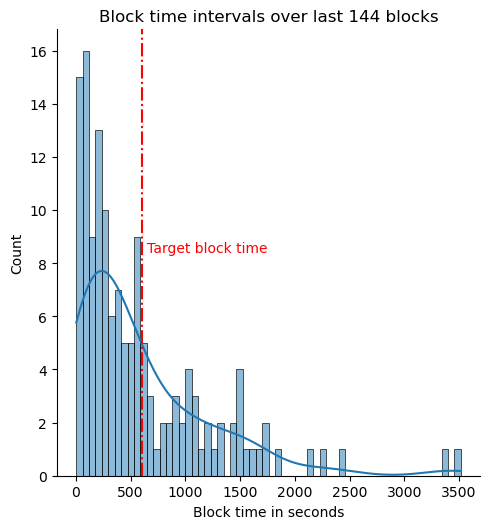

In [20]:
f = sns.displot(data = td_seconds, bins=60, kde=True)
plt.axvline(600, color = 'red', linestyle='-.')
plt.text(650,f.ax.get_ylim()[1]/2,'Target block time', color = 'red',rotation=0)
plt.xlabel('Block time in seconds')
plt.title(f'Block time intervals over last {nblocks} blocks');

Current Hash rate is calculated as expected blocks/found blocks * hash rate set calculated using current difficulty

In [21]:
block_diff=(block_timestamps[0]-block_timestamps[-1]).seconds+(block_timestamps[0]-block_timestamps[-1]).days*3600*24
current_hr = round(nblocks*600/block_diff*hr, 2)
print (f'Current Hash rate based on the last {nblocks} blocks is {current_hr} EH/s')

Current Hash rate based on the last 144 blocks is 275.93 EH/s


## Average Block time

In [22]:
m=int(np.array(td_seconds).mean()//60)
s=int(np.array(td_seconds).mean()%60)
print(f'Average block time is {m}:{s:02d}')

Average block time is 9:49


## Time since last block

In [23]:
m=(datetime.now()-block_timestamps[0]).seconds//60
s=(datetime.now()-block_timestamps[0]).seconds%60
print(f'Time since last block is {m}:{s:02d}')

Time since last block is 17:59


## Estimated Difficulty Adjustment

In [24]:
estimated_difficulty_adj = (current_hr/hr-1)*100
print(f'Estimated diffulty adjustment is  {estimated_difficulty_adj:.2f}%')

Estimated diffulty adjustment is  2.55%


# Miner earnings

daily bitcoin miner earnings = 
(6.25 block reward * Hash/second * 86,400 seconds per day) / (difficulty * 2^32)

In [25]:
daily_earnings = round((6.25*1E18*86400)/(difficulty*1E12*2**32),8)
print(f'Daily earnings from block rewards per EH of hashing power is approximately {daily_earnings} BTC. Calculation does not consider fees.')

Daily earnings from block rewards per EH of hashing power is approximately 3.34473391 BTC. Calculation does not consider fees.


In [26]:
yearly_earnings = round((6.25*1E16*86400)/(difficulty*1E12*2**32),8)*365
print(f'Annual earnings from block rewards per 10PH of hashing power is approximately {yearly_earnings} BTC. Calculation does not consider fees.')

Annual earnings from block rewards per 10PH of hashing power is approximately 12.2082791 BTC. Calculation does not consider fees.


## Miner balance sheet calculation

In [27]:
def btcusd_coinbase():
    endpoint = 'https://api.coinbase.com/v2/exchange-rates?currency=USD'  # this is the coinbase API endpoint for the data
    response = requests.get(endpoint)
    if response.status_code == 200:
        data = json.loads(response.text)
    else:
        raise Exception('Coinbase API call failed')
    return round(1/float(data['data']['rates']['BTC']),2)

In [28]:
miner_cost=6000 #$Cost to procure
elec_cost=0.02 #$Cost of electricity per KWhr
miner_tdp=3 #Miner power consumption in KWh
miner_hp=110*1E12 #Hashing power per miner
n_miners=10*1E15/miner_hp #Total miners to produce 10PH
cap_cost=round(miner_cost*n_miners/1E6,2) #Cap cost in millions of USD
op_cost=round(n_miners*miner_tdp*24*365*elec_cost/1E6,2) #Operational cost
btcusd=btcusd_coinbase() #BTCUSD exchange rate
revenue_dollars=round(yearly_earnings*btcusd/1E6,2)
print(f'Capital cost of miners to produce 10PH/s is ${cap_cost}M. Electricity cost is ${op_cost}M@2c/KWhr, and annual earnings are ${revenue_dollars}M USD based on an BTCUSD exchange rate of ${btcusd}')

Capital cost of miners to produce 10PH/s is $0.55M. Electricity cost is $0.05M@2c/KWhr, and annual earnings are $0.25M USD based on an BTCUSD exchange rate of $20860.57


In [29]:
prod_cost = round(op_cost/yearly_earnings*1E6,2)
print(f'Cost of mining one bitcoin at is ${prod_cost}')

Cost of mining one bitcoin at is $4095.58


In [30]:
gross_margin =round((1-op_cost/revenue_dollars)*100,2)
print(f'Gross margins at {gross_margin}%')

Gross margins at 80.0%
